# <center> Machine Learning in Biology Workshop Part 1

In [ ]:
#@title Mount Google Drive

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#@title Enable GPU (Runtime->Change runtime type -> GPU)
import tensorflow as tf
assert tf.config.list_physical_devices('GPU')

In [ ]:
#@title Install libraries that are not preloaded
!pip install kipoiseq==0.5.2 --quiet > /dev/null

In [ ]:
#@title Import Libraries
import tensorflow as tf
import tensorflow_hub as hub
import pyfaidx
import pandas as pd
import kipoiseq
import numpy as np
from kipoiseq import Interval
import pickle
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pylab as plt
import seaborn as sns
import matplotlib.patches as patches
print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
#@title Necessary Functions

#functions that extract DNA sequence from fasta file
class FastaStringExtractor:

    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()

#fucntion that one hot encodes DNA
def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)

#defining a class that loads Enformer model and perform different operations
class Enformer:

  def __init__(self, tfhub_url):
    self._model = hub.load(tfhub_url).model

  def predict_on_batch(self, inputs):
    predictions = self._model.predict_on_batch(inputs)
    return {k: v.numpy() for k, v in predictions.items()}

  @tf.function
  def contribution_input_grad(self, input_sequence,
                              target_mask, output_head='human'):
    input_sequence = input_sequence[tf.newaxis]

    target_mask_mass = tf.reduce_sum(target_mask)
    with tf.GradientTape() as tape:
      tape.watch(input_sequence)
      prediction = tf.reduce_sum(
          target_mask[tf.newaxis] *
          self._model.predict_on_batch(input_sequence)[output_head]) / target_mask_mass

    input_grad = tape.gradient(prediction, input_sequence) * input_sequence
    input_grad = tf.squeeze(input_grad, axis=0)
    return tf.reduce_sum(input_grad, axis=-1)

def insert_gene_insulator_enhancer(insert_sequence, insulator_sequence, enhancer_sequence, insulator_distance, enhancer_distance, genomic_sequence):
    # Check the genomic sequence length
    if len(genomic_sequence) < len(insert_sequence) + 2*(len(insulator_sequence) + len(enhancer_sequence)) + 2*(insulator_distance + enhancer_distance):
        raise ValueError("The genomic sequence is too short for the given parameters")

    # Calculate the position where to insert the sequence and the insulators
    insert_pos = (len(genomic_sequence) - len(insert_sequence) - 2*(len(insulator_sequence) + len(enhancer_sequence)) - 2*(insulator_distance + enhancer_distance)) // 2

    # Insert the sequence, the insulator sequences, and the enhancer sequences into the genomic sequence
    padded_sequence = (
        genomic_sequence[:insert_pos] +
        enhancer_sequence +
        genomic_sequence[insert_pos + len(enhancer_sequence):insert_pos + len(enhancer_sequence) + enhancer_distance] +
        insulator_sequence +
        genomic_sequence[insert_pos + len(enhancer_sequence) + enhancer_distance + len(insulator_sequence):insert_pos + len(enhancer_sequence) + enhancer_distance + len(insulator_sequence) + insulator_distance] +
        insert_sequence +
        genomic_sequence[insert_pos + len(enhancer_sequence) + enhancer_distance + len(insulator_sequence) + insulator_distance + len(insert_sequence):insert_pos + len(enhancer_sequence) + enhancer_distance + len(insulator_sequence) + 2*insulator_distance + len(insert_sequence)] +
        insulator_sequence +
        genomic_sequence[insert_pos + len(enhancer_sequence) + enhancer_distance + 2*len(insulator_sequence) + 2*insulator_distance + len(insert_sequence):insert_pos + len(enhancer_sequence) + 2*enhancer_distance + 2*len(insulator_sequence) + 2*insulator_distance + len(insert_sequence)] +
        enhancer_sequence +
        genomic_sequence[insert_pos + 2*len(enhancer_sequence) + 2*enhancer_distance + 2*len(insulator_sequence) + 2*insulator_distance + len(insert_sequence):]
    )

    # Ensure the final length is exactly 393_216
    assert len(padded_sequence) == 393_216, f"Error: The final sequence length is {len(padded_sequence)}, not 393_216"

    return padded_sequence

# find all start positions of the substring in a string
def find_all(string, substring):
    start = 0
    while True:
        start = string.find(substring, start)
        if start == -1: return
        yield start
        start += len(substring) # use start += 1 to find overlapping matches

# plot the specific genomic trakcs
def plot_tracks(tracks, interval, height=1.5, gfp_positions=None, insulator_positions=None, enhancer_positions=None):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)

    if gfp_positions:
        for start, end in gfp_positions:
            rect = patches.Rectangle((start, 0), end-start, np.max(y), linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    if insulator_positions:
        for start, end in insulator_positions:
            rect = patches.Rectangle((start, 0), end-start, np.max(y), linewidth=1, edgecolor='b', facecolor='none')
            ax.add_patch(rect)
    if enhancer_positions:
        for start, end in enhancer_positions:
            rect = patches.Rectangle((start, 0), end-start, np.max(y), linewidth=1, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
    sns.despine(top=True, right=True, bottom=True)

  ax.set_xlabel(str(interval))
  plt.tight_layout()

In [ ]:
#@title Loading Enformer and necessary variables

#initialize path and variables
model_path = 'drive/MyDrive/Stem_Cell_ML_Workshop/enformer_model_weights/'
fasta_file = 'drive/MyDrive/Stem_Cell_ML_Workshop/hg19_ucsc.hg19.fasta'
SEQUENCE_LENGTH = 393_216

# will use this to extract sequence
fasta_extractor = FastaStringExtractor(fasta_file)
seq_extractor = kipoiseq.extractors.VariantSeqExtractor(reference_sequence=fasta_extractor)

#load model
model = Enformer(model_path)
print('model loaded')

model loaded


In [ ]:
# define gene insert, promoter, insulator, and enhancer
gfp_gene = 'tacacacgaataaaagataacaaagatgagtaaaggagaagaacttttcactggagttgtcccaattcttgttgaattagatggcgatgttaatgggcaaaaattctctgtcagtggagagggtgaaggtgatgcaacatacggaaaacttacccttaaatttatttgcactactgggaagctacctgttccatggccaacacttgtcactactttctcttatggtgttcaatgcttttcaagatacccagatcatatgaaacagcatgactttttcaagagtgccatgcccgaaggttatgtacaggaaagaactatattttacaaagatgacgggaactacaagacacgtgctgaagtcaagtttgaaggtgatacccttgttaatagaatcgagttaaaaggtattgattttaaagaagatggaaacattcttggacacaaaatggaatacaactataactcacataatgtatacatcatggcagacaaaccaaagaatggaatcaaagttaacttcaaaattagacacaacattaaagatggaagcgttcaattagcagaccattatcaacaaaatactccaattggcgatggccctgtccttttaccagacaaccattacctgtccacacaatctgccctttccaaagatcccaacgaaaagagagatcacatgatccttcttgagtttgtaacagctgctgggattacacatggcatggatgaactatacaaataaatgtccagacttccaattgacactaaagtgtccgaacaattactaaattctcagggttcctggttaaattcaggctgagactttatttatatatttatagattcattaaaattttatgaataatttattgatgttattaataggggctattttcttattaaataggctactggagtgtat'
CMV_promoter = 'CGTTACATAACTTACGGTAAATGGCCCGCCTGGCTGACCGCCCAACGACCCCCGCCCATTGACGTCAATAATGACGTATGTTCCCATAGTAACGCCAATAGGGACTTTCCATTGACGTCAATGGGTGGAGTATTTACGGTAAACTGCCCACTTGGCAGTACATCAAGTGTATCATATGCCAAGTACGCCCCCTATTGACGTCAATGACGGTAAATGGCCCGCCTGGCATTATGCCCAGTACATGACCTTATGGGACTTTCCTACTTGGCAGTACATCTACGTATTAGTCATCGCTATTACCATGGTGATGCGGTTTTGGCAGTACATCAATGGGCGTGGATAGCGGTTTGACTCACGGGGATTTCCAAGTCTCCACCCCATTGACGTCAATGGGAGTTTGTTTTGGCACCAAAATCAACGGGACTTTCCAAAATGTCGTAACAACTCCGCCCCATTGACGCAAATGGGCGGTAGGCGTGTACGGTGGGAGGTCTATATAAGCAGAGCT'
gfp_insert = CMV_promoter.upper()+gfp_gene.upper()
insulator_target = 'ttaaccctagaaagataatcatattgtgacgtacgttaaagataatcatgtgtaaaattgacgcatgtgttttatcggtctgtatatcgaggtttatttattaatttgaatagatattaagttttattatatttacacttacatactaataataaattcaacaaacaatttatttatgtttatttatttattaaaaaaaacaaaaactcaaaatttcttctataaagtaacaaaacttttatgagggacagcccccccccaaagcccccagggatgtaattacgtccctcccccgctagggggcagcagcgagccgcccggggctccgctccggtccggcgctccccccgcatccccgagccggcagcgtgcggggacagcccgggcacggggaaggtggcacgggatcgctttcctctgaacgcttctcgctgctctttgagcctgcagacacctggggggatacggggaaaaggcctccacggccactagcatgggcccatctcgacattgattattgactagttattaatagtaatcaattacggggtcattagttcatagcccatatatggagttccgcgttacataacttacggtaaatggcccgcctggctgaccgcccaacgacccccgcccattgacgtcaataatgacgtatgttcccatagtaacgccaatagggactttccattgacgtcaatgggtggactatttacggtaaactgcccacttggcagtacatcaagtgtatcatatgccaagtacgccccctattgacgtcaatgacggtaaatggcccgcctggcattatgcccagtacatgaccttatgggactttcctacttggcagtacatctacgtattagtcatcgctattaccatgggtcgaggtgagccccacgttctgcttcactctccccatctcccccccctccccacccccaattttgtatttatttattttttaattattttgtgcagcgatgggggcggggggggggggggcgcgcgccaggcggggcggggcggggcgaggggcggggcggggcgaggcggagaggtgcggcggcagccaatcagagcggcgcgctccgaaagtttccttttatggcgaggcggcggcggcggcggccctataaaaagcgaagcgcgcggcgggcgggagtcgctgcgttgccttcgccccgtgccccgctccgcgccgcctcgcgccgcccgccccggctctgactgaccgcgttactcccacaggtgagcgggcgggacggcccttctcctccgggctgtaattagcgcttggtttaatgacggctcgtttcttttctgtggctgcgtgaaagccttaaagggctccgggagggccctttgtgcgggggggagcggctcggggggtgcgtgcgtgtgtgtgtgcgtggggagcgccgcgtgcggcccgcgctgcccggcggctgtgagcgctgcgggcgcggcgcggggctttgtgcgctccgcgtgtgcgcgaggggagcgcggccgggggcggtgccccgcggtgcgggggggctgcgaggggaacaaaggctgcgtgcggggtgtgtgcgtgggggggtgagcagggggtgtgggcgcggcggtcgggctgtaacccccccctgcacccccctccccgagttgctgagcacggcccggcttcgggtgcggggctccgtgcggggcgtggcgcggggctcgccgtgccgggcggggggtggcggcaggtgggggtgccgggcggggcggggccgcctcgggccggggagggctcgggggaggggcgcggcggccccggagcgccggcggctgtcgaggcgcggcgagccgcagccattgccttttatggtaatcgtgcgagagggcgcagggacttcctttgtcccaaatctggcggagccgaaatctgggaggcgccgccgcaccccctctagcgggcgcgggcgaagcggtgcggcgccggcaggaaggaaatgggcggggagggccttcgtgcgtcgccgcgccgccgtccccttctccatctccagcctcggggctgccgcagggggacggctgccttcgggggggacggggcagggcggggttcggcttctggcgtgtgaccggcggctctagagcctctgctaaccatgttcatgccttcttctttttcctacagctcctgggcaacgtgctggttgttgtgctgtctcatcattttggcaaagaattGGGATCCGAATTCCTCGAGGGCGGCCGCctatagggagagccgccaccatgaaacggacagccgacggaagcgagttcgagtcaccaaagaagaagcggaaagtcgacaagaagtacagcatcggcctggccatcggcaccaactctgtgggctgggccgtgatcaccgacgagtacaaggtgcccagcaagaaattcaaggtgctgggcaacaccgaccggcacagcatcaagaagaacctgatcggagccctgctgttcgacagcggcgaaacagccgaggccacccggctgaagagaaccgccagaagaagatacaccagacggaagaaccggatctgctatctgcaagagatcttcagcaacgagatggccaaggtggacgacagcttcttccacagactggaagagtccttcctggtggaagaggataagaagcacgagcggcaccccatcttcggcaacatcgtggacgaggtggcctaccacgagaagtaccccaccatctaccacctgagaaagaaactggtggacagcaccgacaaggccgacctgcggctgatctatctggccctggcccacatgatcaagttccggggccacttcctgatcgagggcgacctgaaccccgacaacagcgacgtggacaagctgttcatccagctggtgcagacctacaaccagctgttcgaggaaaaccccatcaacgccagcggcgtggacgccaaggccatcctgtctgccagactgagcaagagcagacggctggaaaatctgatcgcccagctgcccggcgagaagaagaatggcctgttcggaaacctgattgccctgagcctgggcctgacccccaacttcaagagcaacttcgacctggccgaggatgccaaactgcagctgagcaaggacacctacgacgacgacctggacaacctgctggcccagatcggcgaccagtacgccgacctgtttctggccgccaagaacctgtccgacgccatcctgctgagcgacatcctgagagtgaacaccgagatcaccaaggcccccctgagcgcctctatgatcaagagatacgacgagcaccaccaggacctgaccctgctgaaagctctcgtgcggcagcagctgcctgagaagtacaaagagattttcttcgaccagagcaagaacggctacgccggctacattgacggcggagccagccaggaagagttctacaagttcatcaagcccatcctggaaaagatggacggcaccgaggaactgctcgtgaagctgaacagagaggacctgctgcggaagcagcggaccttcgacaacggcagcatcccccaccagatccacctgggagagctgcacgccattctgcggcggcaggaagatttttacccattcctgaaggacaaccgggaaaagatcgagaagatcctgaccttccgcatcccctactacgtgggccctctggccaggggaaacagcagattcgcctggatgaccagaaagagcgaggaaaccatcaccccctggaacttcgaggaagtggtggacaagggcgcttccgcccagagcttcatcgagcggatgaccaacttcgataagaacctgcccaacgagaaggtgctgcccaagcacagcctgctgtacgagtacttcaccgtgtataacgagctgaccaaagtgaaatacgtgaccgagggaatgagaaagcccgccttcctgagcggcgagcagaaaaaggccatcgtggacctgctgttcaagaccaaccggaaagtgaccgtgaagcagctgaaagaggactacttcaagaaaatcgagtgcttcgactccgtggaaatctccggcgtggaagatcggttcaacgcctccctgggcacataccacgatctgctgaaaattatcaaggacaaggacttcctggacaatgaggaaaacgaggacattctggaagatatcgtgctgaccctgacactgtttgaggacagagagatgatcgaggaacggctgaaaacctatgcccacctgttcgacgacaaagtgatgaagcagctgaagcggcggagatacaccggctggggcaggctgagccggaagctgatcaacggcatccgggacaagcagtccggcaagacaatcctggatttcctgaagtccgacggcttcgccaacagaaacttcatgcagctgatccacgacgacagcctgacctttaaagaggacatccagaaagcccaggtgtccggccagggcgatagcctgcacgagcacattgccaatctggccggcagccccgccattaagaagggcatcctgcagacagtgaaggtggtggacgagctcgtgaaagtgatgggccggcacaagcccgagaacatcgtgatcgaaatggccagagagaaccagaccacccagaagggacagaagaacagccgcgagagaatgaagcggatcgaagagggcatcaaagagctgggcagccagatcctgaaagaacaccccgtggaaaacacccagctgcagaacgagaagctgtacctgtactacctgcagaatgggcgggatatgtacgtggaccaggaactggacatcaaccggctgtccgactacgatgtggaccatatcgtgcctcagagctttctgaaggacgactccatcgacaacaaggtgctgaccagaagcgacaagaaccggggcaagagcgacaacgtgccctccgaagaggtcgtgaagaagatgaagaactactggcggcagctgctgaacgccaagctgattacccagagaaagttcgacaatctgaccaaggccgagagaggcggcctgagcgaactggataaggccggcttcatcaagagacagctggtggaaacccggcagatcacaaagcacgtggcacagatcctggactcccggatgaacactaagtacgacgagaatgacaagctgatccgggaagtgaaagtgatcaccctgaagtccaagctggtgtccgatttccggaaggatttccagttttacaaagtgcgcgagatcaacaactaccaccacgcccacgacgcctacctgaacgccgtcgtgggaaccgccctgatcaaaaagtaccctaagctggaaagcgagttcgtgtacggcgactacaaggtgtacgacgtgcggaagatgatcgccaagagcgagcaggaaatcggcaaggctaccgccaagtacttcttctacagcaacatcatgaactttttcaagaccgagattaccctggccaacggcgagatccggaagcggcctctgatcgagacaaacggcgaaaccggggagatcgtgtgggataagggccgggattttgccaccgtgcggaaagtgctgagcatgccccaagtgaatatcgtgaaaaagaccgaggtgcagacaggcggcttcagcaaagagtctatcctgcccaagaggaacagcgataagctgatcgccagaaagaaggactgggaccctaagaagtacggcggcttcgacagccccaccgtggcctattctgtgctggtggtggccaaagtggaaaagggcaagtccaagaaactgaagagtgtgaaagagctgctggggatcaccatcatggaaagaagcagcttcgagaagaatcccatcgactttctggaagccaagggctacaaagaagtgaaaaaggacctgatcatcaagctgcctaagtactccctgttcgagctggaaaacggccggaagagaatgctggcctctgccggcgaactgcagaagggaaacgaactggccctgccctccaaatatgtgaacttcctgtacctggccagccactatgagaagctgaagggctcccccgaggataatgagcagaaacagctgtttgtggaacagcacaagcactacctggacgagatcatcgagcagatcagcgagttctccaagagagtgatcctggccgacgctaatctggacaaagtgctgtccgcctacaacaagcaccgggataagcccatcagagagcaggccgagaatatcatccacctgtttaccctgaccaatctgggagcccctgccgccttcaagtactttgacaccaccatcgaccggaagaggtacaccagcaccaaagaggtgctggacgccaccctgatccaccagagcatcaccggcctgtacgagacacggatcgacctgtctcagctgggaggtgacGGCGGAGGAGGAACTGGAGGAGGAGGATCAGCAGAATATGTGAGAGCACTGTTTGACTTTAATGGGAATGACGAAGAAGACCTGCCCTTCAAGAAGGGCGACATCCTGCGGATCAGAGATAAGCCTGAGGAGCAGTGGTGGAACGCCGAGGACTCTGAGGGCAAGAGAGGCATGATCCTGGTGCCCTACGTGGAGAAGTACAGCGGCGATTATAAGGACCACGATGGCGACTACAAGGACCACGACATCGACTACAAGGATGACGATGACAAGTCTGGCATGACAGATGCCGAGTATGTGAGAATCCACGAGAAGCTGGACATCTACACCTTCAAGAAGCAGTTTTTCAACAATAAGAAGAGCGTGTCCCACAGATGCTACGTGCTGTTTGAGCTGAAGAGAAGGGGCGAGCGGAGAGCCTGTTTTTGGGGCTACGCCGTGAACAAGCCCCAGTCTGGCACAGAGCGGGGCATCCACGCCGAGATCTTCTCCATCCGGAAGGTGGAGGAGTACCTGCGGGACAACCCAGGCCAGTTCACCATCAACTGGTACAGCTCCTGGTCCCCATGTGCCGACTGTGCCGAGAAGATCCTGGAGTGGTACAACCAGGAGCTGCGGGGCAACGGCCACACCCTGAAGATCTGGGCCTGCAAGCTGTACTATGAGAAGAATGCCAGAAACCAGATCGGCCTGTGGAACCTGAGAGACAATGGCGTGGGCCTGAACGTGATGGTGTCTGAGCACTACCAGTGCTGTAGGAAGATCTTCATCCAGTCTTCCCACAACCAGCTGAATGAGAACAGATGGCTGGAGAAGACACTGAAGCGGGCCGAGAAGTGGAGAAGCGAGCTGTCCATCATGATCCAGGTGAAGATCCTGCACACCACCAAGTCTCCAGCCGTGGGCCCAAAGAAGAAGCGCAAGGTGGGCACCATGACCAACCTGTCTGACATCATCGAGAAGGAGACAGGCAAGCAGCTGGTAATCCAGGAGAGCATCCTGATGCTGCCTGAGGAGGTGGAGGAGGTAATCGGCAACAAGCCTGAGAGCGATATCCTGGTGCACACCGCCTATGATGAGAGCACAGACGAGAACGTGATGCTGCTGACCAGCGACGCCCCTGAGTACAAACCTTGGGCACTGGTCATTCAGGATAGTAACGGGGAGAACAAAATCAAAATGCTGGAAGGCAGGGGAAGCCTTCTGACTTGTGGGGATGTGGAAGAAAACCCTGGTCCACCCAAGAAGAAAAGAAAAGTCATGGTGTCTAAGGGCgaagagctgattaaggagaacatgcacatgaagctgtacatggagggcaccgtggacaaccatcacttcaagtgcacatccgagggcgaaggcaagccctacgagggcacccagaccatgagaatcaaggtggtcgagggcggccctctccccttcgccttcgacatcctggctactagcttcctctacggcagcaagaccttcatcaaccacacccagggcatccccgacttcttcaagcagtccttccctgagggcttcacatgggagagagtcaccacatacgaagacgggggcgtgctgaccgctacccaggacaccagcctccaggacggctgcctcatctacaacgtcaagatcagaggggtgaacttcacatccaacggccctgtgatgcagaagaaaacactcggctgggaggccttcaccgagacgctgtaccccgctgacggcggcctggaaggcagaaacgacatggccctgaagctcgtgggcgggagccatctgatcgcaaacgccaagaccacatatagatccaagaaacccgctaagaacctcaagatgcctggcgtctactatgtggactacagactggaaagaatcaaggaggccaacaacgagacctacgtcgagcagcacgaggtggcagtggccagatactgcgacctccctagCAAACTGGGGCACAAGCTTAATTAGgtcgacaatcaacctctggattacaaaatttgtgaaagattgactggtattcttaactatgttgctccttttacgctatgtggatacgctgctttaatgcctttgtatcatgcgttaactaaacttgtttattgcagcttataatggttacaaataaagcaatagcatcacaaatttcacaaataaagcatttttttcactgcattctagttgtggtttgtccaaactcatcaatgtatcttatcatgtctggaattgactcaaatgatgtcaattagtctatcagaagctcatctggtctcccttccgggggacaagacatccctgtttaatatttaaacagcagtgttcccaaactgggttcttatatcccttgctctggtcaaccaggttgcagggtttcctgtcctcacaggaacgaagtccctaaagaaacagtggcagccaggtttagccccggaattgactggattccttttttagggcccattggtatggctttttccccgtatccccccaggtgtctgcaggctcaaagagcagcgagaagcgttcagaggaaagcgatcccgtgccaccttccccgtgcccgggctgtccccgcacgctgccggctcggggatgcggggggagcgccggaccggagcggagccccgggcggctcgctgctgccccctagcgggggagggacgtaattacatccctgggggctttgggggggggctgtccctgatatctataacaagaaaatatatatataataagttatcacgtaagtagaacatgaaataacaatataattatcgtatgagttaaatcttaaaagtcacgtaaaagataatcatgcgtcattttgactcacgcggtcgttatagttcaaaatcagtgacacttaccgcattgacaagcacgcctcacgggagctccaagcggcgactgagatgtcctaaatgcacagcgacggattcgcgctatttagaaagagagagcaatatttcaagaatgcatgcgtcaattttacgcagactatctttctagggttaa'

enhancer_interval = kipoiseq.Interval('chr1', 111_172_794, 111_180_488)  # @param
enhancer = fasta_extractor.extract(enhancer_interval)

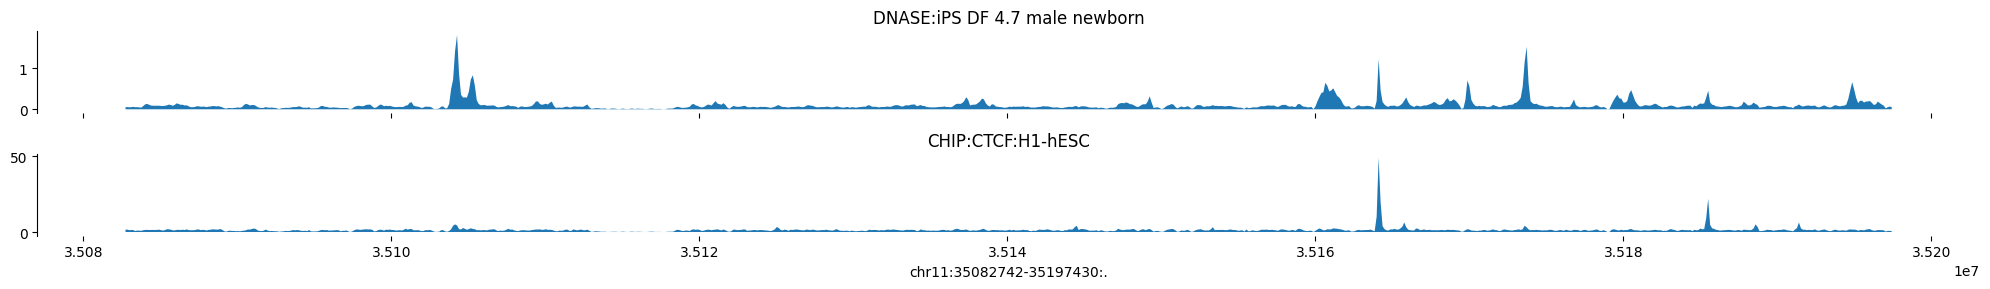

In [ ]:
#@title Making prediction on a genomic region

target_interval = kipoiseq.Interval('chr11', 35_082_742, 35_197_430) # chrom, start, end
genomic_sequence = fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)) #extract the sequence (resize the sequence to 393_216 length as the model graph expects this length as input though it uses only center 196_608 bp!)
sequence_one_hot = one_hot_encode(genomic_sequence)
predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]

tracks = {'DNASE:iPS DF 4.7 male newborn': predictions[:, 170],
          'CHIP:CTCF:H1-hESC': predictions[:, 712]
        }
plot_tracks(tracks, target_interval)

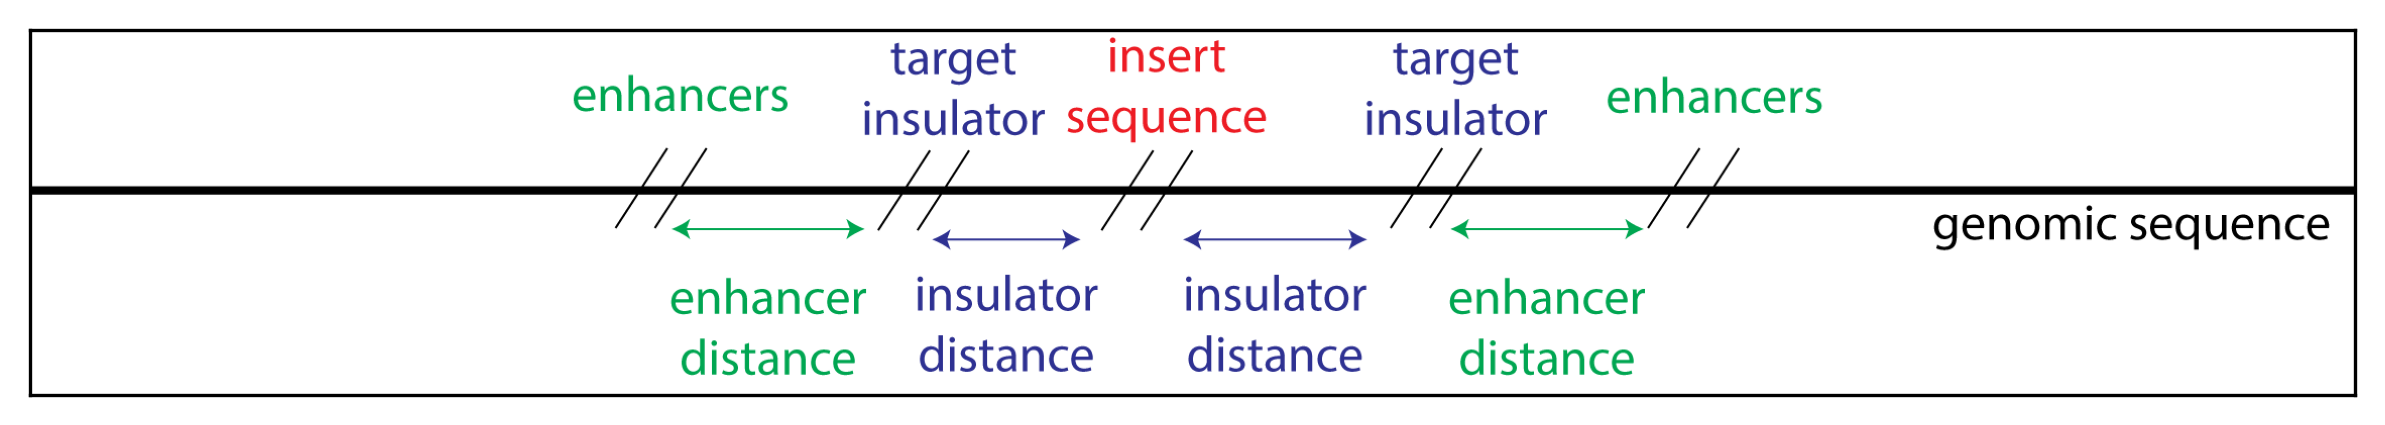

In [ ]:
#@title Let's try to asssess the strength of an insulator at a genomic locus

img = plt.imread('drive/MyDrive/Stem_Cell_ML_Workshop/insert_fragment_into_genome.png')
plt.figure(figsize=(10, 8), dpi=300)
plt.xticks([])
plt.yticks([])
plt.imshow(img)


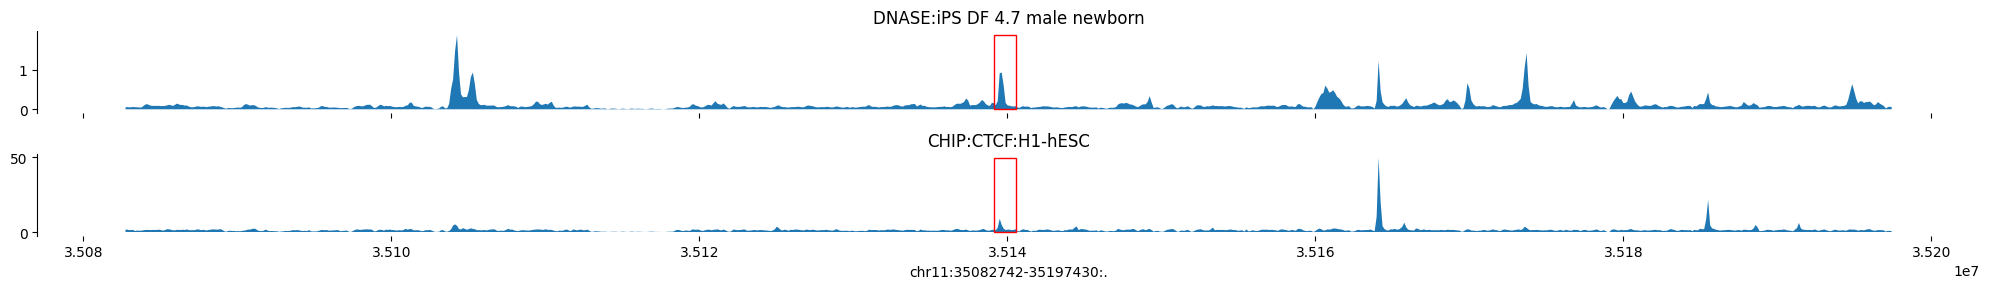

In [ ]:
#@title Making prediction on the GFP gene inserted into this genomic locus
genomic_insulated_sequence = insert_gene_insulator_enhancer(insert_sequence=gfp_insert, insulator_sequence='', enhancer_sequence='',
                                                                   insulator_distance=0, enhancer_distance=0, genomic_sequence=genomic_sequence.upper())
sequence_one_hot = one_hot_encode(genomic_insulated_sequence)
predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]

# @title Plot tracks
tracks = {'DNASE:iPS DF 4.7 male newborn': predictions[:, 170],
          'CHIP:CTCF:H1-hESC': predictions[:, 712]
        }
gfp_positions = [(target_interval.start+genomic_insulated_sequence.find(gfp_insert)-(393_216-114_176)//2, target_interval.start+genomic_insulated_sequence.find(gfp_insert)-(393_216-114_176)//2+len(gfp_insert)),
                 ]
plot_tracks(tracks, target_interval, gfp_positions=gfp_positions)

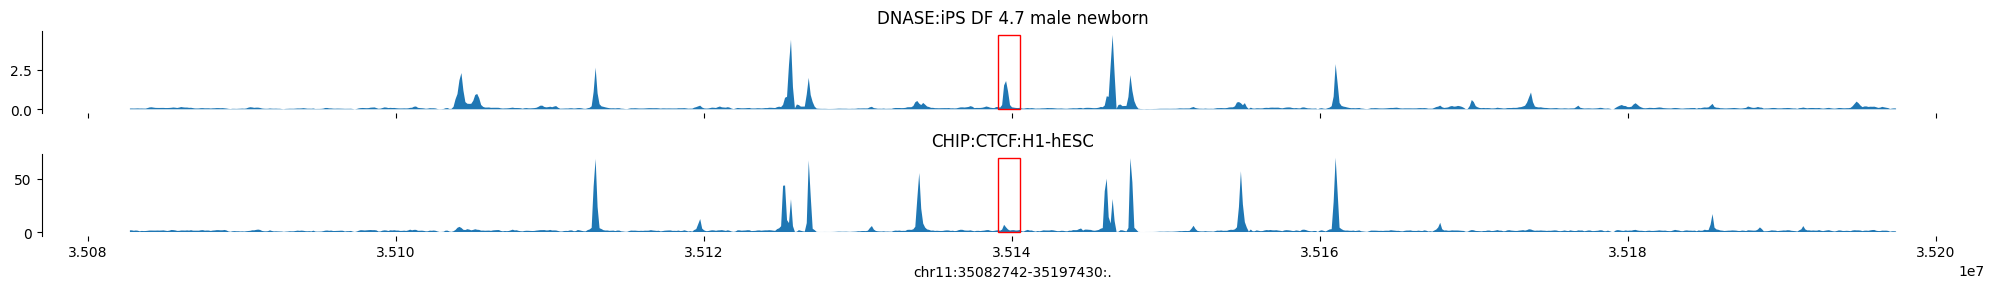

In [ ]:
#@title Making prediction on the GFP gene inserted into this genomic locus along with enhancers and insulators

genomic_insulated_sequence = insert_gene_insulator_enhancer(insert_sequence=gfp_insert, insulator_sequence=insulator_target.upper(), enhancer_sequence=enhancer.upper(),
                                                             insulator_distance=5_000, enhancer_distance=5_000, genomic_sequence=genomic_sequence.upper())
sequence_one_hot = one_hot_encode(genomic_insulated_sequence)
insulator_predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]

# @title Plot tracks
tracks = {'DNASE:iPS DF 4.7 male newborn': insulator_predictions[:, 170],
          'CHIP:CTCF:H1-hESC': insulator_predictions[:, 712]}
gfp_positions = [(target_interval.start+genomic_insulated_sequence.find(gfp_insert)-(393_216-114_176)//2, target_interval.start+genomic_insulated_sequence.find(gfp_insert)-(393_216-114_176)//2+len(gfp_insert)),
                 ]
plot_tracks(tracks, target_interval, gfp_positions=gfp_positions)

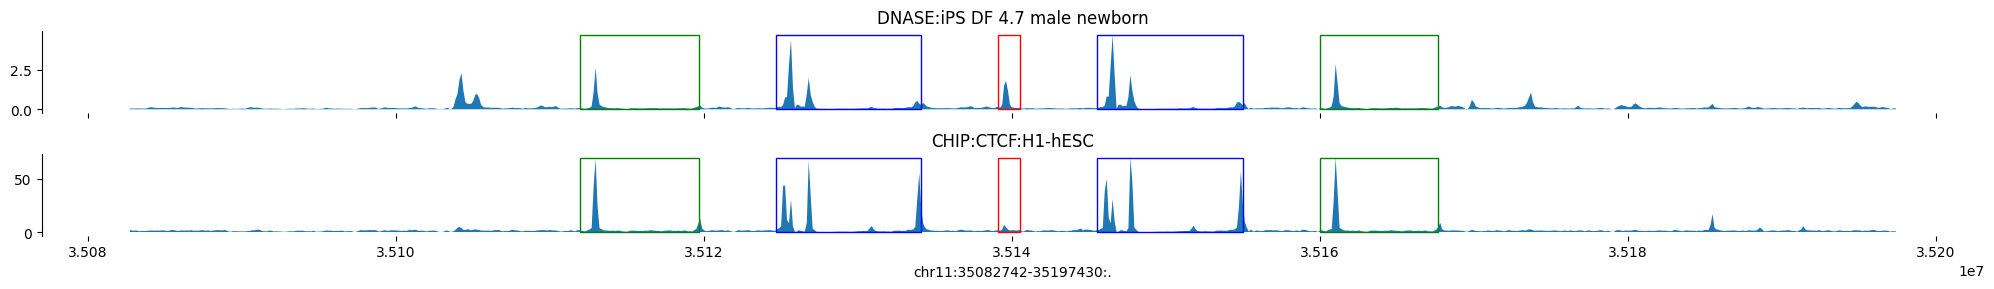

In [ ]:
insulator_indices = list(find_all(genomic_insulated_sequence, insulator_target.upper()))
enhancer_indices = list(find_all(genomic_insulated_sequence, enhancer.upper()))
gfp_indices = list(find_all(genomic_insulated_sequence, gfp_insert.upper()))

insulator_positions = [
    (
        target_interval.start + idx - (393_216 - 114_176) // 2,
        target_interval.start + idx - (393_216 - 114_176) // 2 + len(insulator_target)
    ) for idx in insulator_indices
]

enhancer_positions = [
    (
        target_interval.start + idx - (393_216 - 114_176) // 2,
        target_interval.start + idx - (393_216 - 114_176) // 2 + len(enhancer)
    ) for idx in enhancer_indices
]

gfp_positions = [
    (
        target_interval.start + idx - (393_216 - 114_176) // 2,
        target_interval.start + idx - (393_216 - 114_176) // 2 + len(gfp_insert)
    ) for idx in gfp_indices
]
plot_tracks(tracks, target_interval, gfp_positions=gfp_positions, insulator_positions = insulator_positions, enhancer_positions=enhancer_positions)

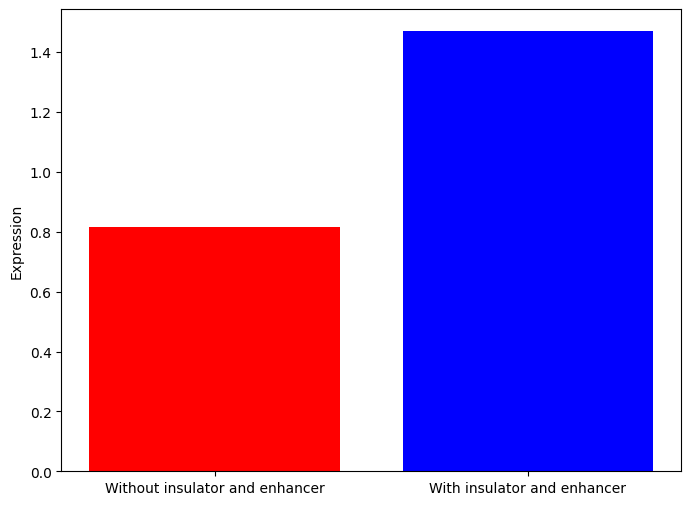

In [ ]:
#@title A bar chart showing CAGE at the TSS with/without insulators/enhancers

# identify the output bin for the TSS site
TSS = (genomic_insulated_sequence.find(gfp_gene.upper())-(393_216-114_176)//2)//128

#predictions has shape (896, 5313) accessing TSS bin and 170th track. Also taking the average of 3 bins around the TSS
gfp_alone = (predictions[TSS, 170] + predictions[TSS-1, 170] + predictions[TSS+1, 170])/3
gfp_with_ins_enh = (insulator_predictions[TSS, 170] + insulator_predictions[TSS-1, 170] + insulator_predictions[TSS+1, 170])/3

values = [gfp_alone, gfp_with_ins_enh]

labels = ['Without insulator and enhancer', 'With insulator and enhancer']  # your labels

plt.figure(figsize=(8, 6), dpi=100)

plt.bar(labels, values, color=['red', 'blue'])

plt.ylabel('Expression')
plt.show()

In [ ]:
#@title For some models only weights may be available. we need to define the model graph and load weights



import tensorflow.keras as keras  ## important to make sure non tf.keras is hidden

### Reference to helpful open sourced libraries utilized in this project :
##https://github.com/CyberZHG ### Thanks CyberZHG !
#from keras_multi_head import MultiHeadAttention , MultiHead
#from keras_position_wise_feed_forward import FeedForward
#from keras_layer_normalization import LayerNormalization
##https://github.com/CyberZHG
#http://colorbrewer2.org/#type=sequential&scheme=BuGn&n=9


import argparse,pwd,os,numpy as np,h5py
from os import makedirs
from os.path import splitext,exists,dirname,join,basename , realpath
import multiprocessing as mp, ctypes
from sklearn.metrics import *
from scipy.stats import *
import time , csv ,pickle ,joblib , matplotlib  , multiprocessing,itertools
from joblib import Parallel, delayed
import seaborn as sns
import os, gc , datetime , sklearn , scipy , pydot , random
from tqdm import tqdm
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.client import device_lib
from tensorflow.keras import Input
from tensorflow.keras.layers import  Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten , Conv1D, Concatenate , Permute
from tensorflow.keras.layers import Bidirectional,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Add , LeakyReLU ,Reshape , Activation , MaxPooling1D , Lambda , Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.backend import conv1d
from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import h5py , tensorflow
import tensorflow as tf, sys, numpy as np, h5py, pandas as pd
from tensorflow import nn
from os import makedirs
#from tensorflow.keras.utils import multi_gpu_model
import glob , math
##Matplotlib rc params
# Font family : https://matplotlib.org/tutorials/introductory/customizing.html , http://aeturrell.com/2018/01/31/publication-quality-plots-in-python/ , https://www.dmcdougall.co.uk/publication-ready-the-first-time-beautiful-reproducible-plots-with-matplotlib , https://stackoverflow.com/questions/26106552/matplotlib-style-library-not-updating-when-mplstyle-files-added-deleted , https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html , http://www.jesshamrick.com/2016/04/13/reproducible-plots/ ,
#
from matplotlib import rcParams
rcParams.update(matplotlib.rcParamsDefault)
rcParams['pdf.fonttype'] = 42

### Function to embed sequences and another one to get reverse complements , made for 6.874
# Function expects a list of strings in the data field
def old_seq2feature(data):
    A_onehot = np.array([1,0,0,0] ,  dtype=np.bool)
    C_onehot = np.array([0,1,0,0] ,  dtype=np.bool)
    G_onehot = np.array([0,0,1,0] ,  dtype=np.bool)
    T_onehot = np.array([0,0,0,1] ,  dtype=np.bool)
    N_onehot = np.array([0,0,0,0] ,  dtype=np.bool)

    mapper = {'A':A_onehot,'C':C_onehot,'G':G_onehot,'T':T_onehot,'N':N_onehot}
    worddim = len(mapper['A'])

    ###Make sure the length is 110bp
    for i in (range(0,len(data))) :
        if (len(data[i]) > 110) :
            data[i] = data[i][-110:]
        elif (len(data[i]) < 110) :
            while (len(data[i]) < 110) :
                data[i] = 'N'+data[i]

    #data = np.asarray(data)
    #transformed = np.zeros([len(data),len(data[0]),4] , dtype=np.bool )
    #for i in (range(len(data))) :
    #    for j,k in enumerate(data[i]):
    #        transformed[i,j] = mapper[k]
    transformed = np.asarray(([[mapper[k] for k in (data[i])] for i in (range(len(data)))]))
    return transformed

def load_model(model_conditions ) :
    NUM_GPU = len(get_available_gpus())
    dir_path=os.path.join('..','..','..','data',model_conditions)
    model_path=os.path.join(dir_path,"fitness_function.h5")

    ### Load the parameters used for training the model
    f = open(os.path.join(dir_path,'model_params.pkl'),"rb")
    model_params = pickle.load(f)
    batch_size = model_params['batch_size']
    f.close()



    ### Load the model on multiple GPUs with the largest possible batch size
    #if NUM_GPU > 0 :
    scaler= sklearn.externals.joblib.load(os.path.join(dir_path,'scaler.save'))
    model_params['batch_size'] = np.power(2,10 + NUM_GPU)
    batch_size = model_params['batch_size']
    model_params['device_type'] = 'gpu'
    model = fitness_function_model(model_params)
    model.load_weights(model_path)
    if NUM_GPU > 1 :
        model = tf.keras.utils.multi_gpu_model(model,NUM_GPU,cpu_merge=True,cpu_relocation=False)

    if 0 : #Change to 1 if using TPU ## Changing the batch size on using the tf.keras.models.load_model is not permitted,but TPU needs this
        scaler= sklearn.externals.joblib.load(os.path.join(dir_path,'scaler.save'))
        batch_size = model_params['batch_size']
        model_params['device_type'] = 'tpu'
        model = fitness_function_model(model_params)
        model.load_weights(model_path)

        if(model_params['device_type']=='tpu'):
            tpu_name = os.environ['TPU_NAME']
            tpu_grpc_url = TPUClusterResolver(tpu=[tpu_name] , zone='us-central1-a').get_master()
            if(tpu_grpc_url) :
                model = tf.contrib.tpu.keras_to_tpu_model(model,
                        strategy=tf.contrib.tpu.TPUDistributionStrategy(
                            tf.contrib.cluster_resolver.TPUClusterResolver(tpu_grpc_url)))

            if 0 :
                model = tensorflow.keras.models.load_model(model_path , custom_objects={
                    'MultiHeadAttention' : MultiHeadAttention ,
                    'FeedForward' : FeedForward,
                    'correlation_coefficient' : correlation_coefficient,
                    'LayerNormalization' : LayerNormalization,
                    'rc_Conv1D' : rc_Conv1D})
    return model , scaler, batch_size

### Starting point for this layer was : https://github.com/kundajelab/keras-genomics/blob/master/keras_genomics/layers/convolutional.py which was modified and adapted for our purpose , I don't think we end up using it anywhere, but keeping it here just in case something depends on it.
class rc_Conv1D(Conv1D):

    def compute_output_shape(self, input_shape):
        length = conv_utils.conv_output_length(input_shape[1],
                                               self.kernel_size[0],
                                               padding=self.padding,
                                               stride=self.strides[0])
        return [(int(input_shape[0]), int(length), int(self.filters)),
                (int(input_shape[0]), int(length), int(self.filters))]

    def call(self, inputs):
        #create a rev-comped kernel.
        #kernel shape is (width, input_channels, filters)
        #Rev comp is along both the length (dim 0) and input channel (dim 1)
        #axes; that is the reason for ::-1, ::-1 in the first and second dims.
        #The rev-comp of channel at index i should be at index i
        revcomp_kernel =\
            K.concatenate([self.kernel,
                           self.kernel[::-1,::-1,:]],axis=-1)
        if (self.use_bias):
            revcomp_bias = K.concatenate([self.bias,
                                          self.bias], axis=-1)

        outputs = K.conv1d(inputs, revcomp_kernel,
                           strides=self.strides[0],
                           padding=self.padding,
                           data_format=self.data_format,
                           dilation_rate=self.dilation_rate[0])

        if self.use_bias:
            outputs = K.bias_add(outputs,
                                  revcomp_bias,
                                  data_format=self.data_format)

        if (self.activation is not None):
            outputs = self.activation(outputs)
        x_f = outputs[:,:,:int(outputs.get_shape().as_list()[-1]/2)]
        x_rc = outputs[:,:,int(outputs.get_shape().as_list()[-1]/2):]

        return [x_f,x_rc]


class RevCompConv1D(Conv1D):

    def compute_output_shape(self, input_shape):
        length = conv_utils.conv_output_length(input_shape[1],
                                               self.kernel_size[0],
                                               padding=self.padding,
                                               stride=self.strides[0])
        return (input_shape[0], length, 2*self.filters)

    def call(self, inputs):
        #create a rev-comped kernel.
        #kernel shape is (width, input_channels, filters)
        #Rev comp is along both the length (dim 0) and input channel (dim 1)
        #axes; that is the reason for ::-1, ::-1 in the first and second dims.
        #The rev-comp of channel at index i should be at index -i
        #This is the reason for the ::-1 in the last dim.
        revcomp_kernel =\
            K.concatenate([self.kernel,
                           self.kernel[::-1,::-1,::-1]],axis=-1)
        if (self.use_bias):
            revcomp_bias = K.concatenate([self.bias,
                                          self.bias[::-1]], axis=-1)

        outputs = K.conv1d(inputs, revcomp_kernel,
                           strides=self.strides[0],
                           padding=self.padding,
                           data_format=self.data_format,
                           dilation_rate=self.dilation_rate[0])

        if self.use_bias:
            outputs += K.bias_add(outputs,
                                  revcomp_bias,
                                  data_format=self.data_format)

        if (self.activation is not None):
            outputs = self.activation(outputs)
        return outputs



### All the classes below this line are adapted/modified for our purposes from : https://github.com/CyberZHG
### ( Thanks CyberZHG ! )
###
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import copy





class ScaledDotProductAttention(keras.layers.Layer):
    r"""The attention layer that takes three inputs representing queries, keys and values.
    \text{Attention}(Q, K, V) = \text{softmax}(\frac{Q K^T}{\sqrt{d_k}}) V
    See: https://arxiv.org/pdf/1706.03762.pdf
    """

    def __init__(self,
                 return_attention=False,
                 history_only=False,
                 **kwargs):
        """Initialize the layer.
        :param return_attention: Whether to return attention weights.
        :param history_only: Whether to only use history data.
        :param kwargs: Arguments for parent class.
        """
        super(ScaledDotProductAttention, self).__init__(**kwargs)
        self.supports_masking = True
        self.return_attention = return_attention
        self.history_only = history_only

    def get_config(self):
        config = {
            'return_attention': self.return_attention,
            'history_only': self.history_only,
        }
        base_config = super(ScaledDotProductAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            query_shape, key_shape, value_shape = input_shape
        else:
            query_shape = key_shape = value_shape = input_shape
        output_shape = query_shape[:-1] + value_shape[-1:]
        if self.return_attention:
            attention_shape = query_shape[:2] + (key_shape[1],)
            return [output_shape, attention_shape]
        return output_shape

    def compute_mask(self, inputs, mask=None):
        if isinstance(mask, list):
            mask = mask[0]
        if self.return_attention:
            return [mask, None]
        return mask

    def call(self, inputs, mask=None, **kwargs):
        if isinstance(inputs, list):
            query, key, value = inputs
        else:
            query = key = value = inputs
        if isinstance(mask, list):
            mask = mask[1]
        feature_dim = K.shape(query)[-1]
        e = K.batch_dot(query, key, axes=2) / K.sqrt(K.cast(feature_dim, dtype=K.floatx()))
        e = K.exp(e - K.max(e, axis=-1, keepdims=True))
        if self.history_only:
            query_len, key_len = K.shape(query)[1], K.shape(key)[1]
            indices = K.expand_dims(K.arange(key_len), axis=0)
            upper = K.expand_dims(K.arange(query_len), axis=-1)
            e *= K.expand_dims(K.cast(indices <= upper, K.floatx()), axis=0)
        if mask is not None:
            e *= K.cast(K.expand_dims(mask, axis=-2), K.floatx())
        a = e / (K.sum(e, axis=-1, keepdims=True) + K.epsilon())
        v = K.batch_dot(a, value)
        if self.return_attention:
            return [v, a]
        return v



class SeqSelfAttention(keras.layers.Layer):

    ATTENTION_TYPE_ADD = 'additive'
    ATTENTION_TYPE_MUL = 'multiplicative'

    def __init__(self,
                 units=32,
                 attention_width=None,
                 attention_type=ATTENTION_TYPE_ADD,
                 return_attention=False,
                 history_only=False,
                 kernel_initializer='glorot_normal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 use_additive_bias=True,
                 use_attention_bias=True,
                 attention_activation=None,
                 attention_regularizer_weight=0.0,
                 **kwargs):
        """Layer initialization.
        For additive attention, see: https://arxiv.org/pdf/1806.01264.pdf
        :param units: The dimension of the vectors that used to calculate the attention weights.
        :param attention_width: The width of local attention.
        :param attention_type: 'additive' or 'multiplicative'.
        :param return_attention: Whether to return the attention weights for visualization.
        :param history_only: Only use historical pieces of data.
        :param kernel_initializer: The initializer for weight matrices.
        :param bias_initializer: The initializer for biases.
        :param kernel_regularizer: The regularization for weight matrices.
        :param bias_regularizer: The regularization for biases.
        :param kernel_constraint: The constraint for weight matrices.
        :param bias_constraint: The constraint for biases.
        :param use_additive_bias: Whether to use bias while calculating the relevance of inputs features
                                  in additive mode.
        :param use_attention_bias: Whether to use bias while calculating the weights of attention.
        :param attention_activation: The activation used for calculating the weights of attention.
        :param attention_regularizer_weight: The weights of attention regularizer.
        :param kwargs: Parameters for parent class.
        """
        super(SeqSelfAttention, self).__init__(**kwargs)
        self.supports_masking = True
        self.units = units
        self.attention_width = attention_width
        self.attention_type = attention_type
        self.return_attention = return_attention
        self.history_only = history_only
        if history_only and attention_width is None:
            self.attention_width = int(1e9)

        self.use_additive_bias = use_additive_bias
        self.use_attention_bias = use_attention_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)
        self.kernel_constraint = keras.constraints.get(kernel_constraint)
        self.bias_constraint = keras.constraints.get(bias_constraint)
        self.attention_activation = keras.activations.get(attention_activation)
        self.attention_regularizer_weight = attention_regularizer_weight
        self._backend = keras.backend.backend()

        if attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            self.Wx, self.Wt, self.bh = None, None, None
            self.Wa, self.ba = None, None
        elif attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            self.Wa, self.ba = None, None
        else:
            raise NotImplementedError('No implementation for attention type : ' + attention_type)

    def get_config(self):
        config = {
            'units': int(self.units),
            'attention_width': self.attention_width,
            'attention_type': self.attention_type,
            'return_attention': self.return_attention,
            'history_only': self.history_only,
            'use_additive_bias': self.use_additive_bias,
            'use_attention_bias': self.use_attention_bias,
            'kernel_initializer': keras.regularizers.serialize(self.kernel_initializer),
            'bias_initializer': keras.regularizers.serialize(self.bias_initializer),
            'kernel_regularizer': keras.regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': keras.regularizers.serialize(self.bias_regularizer),
            'kernel_constraint': keras.constraints.serialize(self.kernel_constraint),
            'bias_constraint': keras.constraints.serialize(self.bias_constraint),
            'attention_activation': keras.activations.serialize(self.attention_activation),
            'attention_regularizer_weight': self.attention_regularizer_weight,
        }
        base_config = super(SeqSelfAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        if self.attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            self._build_additive_attention(input_shape)
        elif self.attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            self._build_multiplicative_attention(input_shape)
        super(SeqSelfAttention, self).build(input_shape)

    def _build_additive_attention(self, input_shape):
        feature_dim = int(input_shape[2])

        self.Wt = self.add_weight(shape=(feature_dim, self.units),
                                  name='{}_Add_Wt'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        self.Wx = self.add_weight(shape=(feature_dim, self.units),
                                  name='{}_Add_Wx'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_additive_bias:
            self.bh = self.add_weight(shape=(self.units,),
                                      name='{}_Add_bh'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

        self.Wa = self.add_weight(shape=(self.units, 1),
                                  name='{}_Add_Wa'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_attention_bias:
            self.ba = self.add_weight(shape=(1,),
                                      name='{}_Add_ba'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

    def _build_multiplicative_attention(self, input_shape):
        feature_dim = input_shape[2]

        self.Wa = self.add_weight(shape=(feature_dim, feature_dim),
                                  name='{}_Mul_Wa'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_attention_bias:
            self.ba = self.add_weight(shape=(1,),
                                      name='{}_Mul_ba'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

    def call(self, inputs, mask=None, **kwargs):
        input_len = K.shape(inputs)[1]

        if self.attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            e = self._call_additive_emission(inputs)
        elif self.attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            e = self._call_multiplicative_emission(inputs)

        if self.attention_activation is not None:
            e = self.attention_activation(e)
        e = K.exp(e - K.max(e, axis=-1, keepdims=True))
        if self.attention_width is not None:
            if self.history_only:
                lower = K.arange(input_len) - (self.attention_width - 1)
            else:
                lower = K.arange(input_len) - self.attention_width // 2
            lower = K.expand_dims(lower, axis=-1)
            upper = lower + self.attention_width
            indices = K.expand_dims(K.arange(input_len), axis=0)
            e = e * K.cast(lower <= indices, K.floatx()) * K.cast(indices < upper, K.floatx())
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            mask = K.expand_dims(mask)
            e = K.permute_dimensions(K.permute_dimensions(e * mask, (0, 2, 1)) * mask, (0, 2, 1))

        # a_{t} = \text{softmax}(e_t)
        s = K.sum(e, axis=-1, keepdims=True)
        a = e / (s + K.epsilon())

        # l_t = \sum_{t'} a_{t, t'} x_{t'}
        v = K.batch_dot(a, inputs)
        if self.attention_regularizer_weight > 0.0:
            self.add_loss(self._attention_regularizer(a))

        if self.return_attention:
            return [v, a]
        return v

    def _call_additive_emission(self, inputs):
        input_shape = K.shape(inputs)
        batch_size, input_len = input_shape[0], input_shape[1]

        # h_{t, t'} = \tanh(x_t^T W_t + x_{t'}^T W_x + b_h)
        q = K.expand_dims(K.dot(inputs, self.Wt), 2)
        k = K.expand_dims(K.dot(inputs, self.Wx), 1)
        if self.use_additive_bias:
            h = K.tanh(q + k + self.bh)
        else:
            h = K.tanh(q + k)

        # e_{t, t'} = W_a h_{t, t'} + b_a
        if self.use_attention_bias:
            e = K.reshape(K.dot(h, self.Wa) + self.ba, (batch_size, input_len, input_len))
        else:
            e = K.reshape(K.dot(h, self.Wa), (batch_size, input_len, input_len))
        return e

    def _call_multiplicative_emission(self, inputs):
        # e_{t, t'} = x_t^T W_a x_{t'} + b_a
        e = K.batch_dot(K.dot(inputs, self.Wa), K.permute_dimensions(inputs, (0, 2, 1)))
        if self.use_attention_bias:
            e += self.ba[0]
        return e

    def compute_output_shape(self, input_shape):
        output_shape = input_shape
        if self.return_attention:
            attention_shape = (input_shape[0], output_shape[1], input_shape[1])
            return [output_shape, attention_shape]
        return output_shape

    def compute_mask(self, inputs, mask=None):
        if self.return_attention:
            return [mask, None]
        return mask

    def _attention_regularizer(self, attention):
        batch_size = K.cast(K.shape(attention)[0], K.floatx())
        input_len = K.shape(attention)[-1]
        indices = K.tile(K.expand_dims(K.arange(input_len), axis=0), [input_len, 1])
        diagonal = K.expand_dims(K.arange(input_len), axis=-1)
        eye = K.cast(K.equal(indices, diagonal), K.floatx())
        return self.attention_regularizer_weight * K.sum(K.square(K.batch_dot(
            attention,
            K.permute_dimensions(attention, (0, 2, 1))) - eye)) / batch_size

    @staticmethod
    def get_custom_objects():
        return {'SeqSelfAttention': SeqSelfAttention}



class SeqWeightedAttention(keras.layers.Layer):
    r"""Y = \text{softmax}(XW + b) X
    See: https://arxiv.org/pdf/1708.00524.pdf
    """

    def __init__(self, use_bias=True, return_attention=False, **kwargs):
        super(SeqWeightedAttention, self).__init__(**kwargs)
        self.supports_masking = True
        self.use_bias = use_bias
        self.return_attention = return_attention
        self.W, self.b = None, None

    def get_config(self):
        config = {
            'use_bias': self.use_bias,
            'return_attention': self.return_attention,
        }
        base_config = super(SeqWeightedAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_W'.format(self.name),
                                 initializer=keras.initializers.get('uniform'))
        if self.use_bias:
            self.b = self.add_weight(shape=(1,),
                                     name='{}_b'.format(self.name),
                                     initializer=keras.initializers.get('zeros'))
        super(SeqWeightedAttention, self).build(input_shape)

    def call(self, x, mask=None):
        logits = K.dot(x, self.W)
        if self.use_bias:
            logits += self.b
        x_shape = K.shape(x)
        logits = K.reshape(logits, (x_shape[0], x_shape[1]))
        ai = K.exp(logits - K.max(logits, axis=-1, keepdims=True))
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            ai = ai * mask
        att_weights = ai / (K.sum(ai, axis=1, keepdims=True) + K.epsilon())
        weighted_input = x * K.expand_dims(att_weights)
        result = K.sum(weighted_input, axis=1)
        if self.return_attention:
            return [result, att_weights]
        return result

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return input_shape[0], output_len

    def compute_mask(self, _, input_mask=None):
        if self.return_attention:
            return [None, None]
        return None

    @staticmethod
    def get_custom_objects():
        return {'SeqWeightedAttention': SeqWeightedAttention}



class LayerNormalization(keras.layers.Layer):

    def __init__(self,
                 center=True,
                 scale=True,
                 epsilon=None,
                 gamma_initializer='ones',
                 beta_initializer='zeros',
                 gamma_regularizer=None,
                 beta_regularizer=None,
                 gamma_constraint=None,
                 beta_constraint=None,
                 **kwargs):
        """Layer normalization layer
        See: [Layer Normalization](https://arxiv.org/pdf/1607.06450.pdf)
        :param center: Add an offset parameter if it is True.
        :param scale: Add a scale parameter if it is True.
        :param epsilon: Epsilon for calculating variance.
        :param gamma_initializer: Initializer for the gamma weight.
        :param beta_initializer: Initializer for the beta weight.
        :param gamma_regularizer: Optional regularizer for the gamma weight.
        :param beta_regularizer: Optional regularizer for the beta weight.
        :param gamma_constraint: Optional constraint for the gamma weight.
        :param beta_constraint: Optional constraint for the beta weight.
        :param kwargs:
        """
        super(LayerNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.center = center
        self.scale = scale
        if epsilon is None:
            epsilon = K.epsilon() * K.epsilon()
        self.epsilon = epsilon
        self.gamma_initializer = keras.initializers.get(gamma_initializer)
        self.beta_initializer = keras.initializers.get(beta_initializer)
        self.gamma_regularizer = keras.regularizers.get(gamma_regularizer)
        self.beta_regularizer = keras.regularizers.get(beta_regularizer)
        self.gamma_constraint = keras.constraints.get(gamma_constraint)
        self.beta_constraint = keras.constraints.get(beta_constraint)
        self.gamma, self.beta = None, None

    def get_config(self):
        config = {
            'center': self.center,
            'scale': self.scale,
            'epsilon': self.epsilon,
            'gamma_initializer': keras.initializers.serialize(self.gamma_initializer),
            'beta_initializer': keras.initializers.serialize(self.beta_initializer),
            'gamma_regularizer': keras.regularizers.serialize(self.gamma_regularizer),
            'beta_regularizer': keras.regularizers.serialize(self.beta_regularizer),
            'gamma_constraint': keras.constraints.serialize(self.gamma_constraint),
            'beta_constraint': keras.constraints.serialize(self.beta_constraint),
        }
        base_config = super(LayerNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

    def compute_mask(self, inputs, input_mask=None):
        return input_mask

    def build(self, input_shape):
        self.input_spec = keras.layers.InputSpec(shape=input_shape)
        shape = input_shape[-1:]
        if self.scale:
            self.gamma = self.add_weight(
                shape=shape,
                initializer=self.gamma_initializer,
                regularizer=self.gamma_regularizer,
                constraint=self.gamma_constraint,
                name='gamma',
            )
        if self.center:
            self.beta = self.add_weight(
                shape=shape,
                initializer=self.beta_initializer,
                regularizer=self.beta_regularizer,
                constraint=self.beta_constraint,
                name='beta',
            )
        super(LayerNormalization, self).build(input_shape)

    def call(self, inputs, training=None):
        mean = K.mean(inputs, axis=-1, keepdims=True)
        variance = K.mean(K.square(inputs - mean), axis=-1, keepdims=True)
        std = K.sqrt(variance + self.epsilon)
        outputs = (inputs - mean) / std
        if self.scale:
            outputs *= self.gamma
        if self.center:
            outputs += self.beta
        return outputs



class FeedForward(keras.layers.Layer):
    """Position-wise feed-forward layer.
    See: https://arxiv.org/pdf/1706.03762.pdf
    """

    def __init__(self,
                 units,
                 activation='relu',
                 use_bias=True,
                 kernel_initializer='glorot_normal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        """Initialize the layer.
        :param units: Dimension of hidden units.
        :param activation: Activation for the first linear transformation.
        :param use_bias: Whether to use the bias term.
        :param kernel_initializer: Initializer for kernels.
        :param bias_initializer: Initializer for kernels.
        :param kernel_regularizer: Regularizer for kernels.
        :param bias_regularizer: Regularizer for kernels.
        :param kernel_constraint: Constraint for kernels.
        :param bias_constraint: Constraint for kernels.
        :param kwargs:
        """
        self.supports_masking = True
        self.units = int(units)
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)
        self.kernel_constraint = keras.constraints.get(kernel_constraint)
        self.bias_constraint = keras.constraints.get(bias_constraint)
        self.W1, self.b1 = None, None
        self.W2, self.b2 = None, None
        super(FeedForward, self).__init__(**kwargs)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': keras.activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': keras.initializers.serialize(self.kernel_initializer),
            'bias_initializer': keras.initializers.serialize(self.bias_initializer),
            'kernel_regularizer': keras.regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': keras.regularizers.serialize(self.bias_regularizer),
            'kernel_constraint': keras.constraints.serialize(self.kernel_constraint),
            'bias_constraint': keras.constraints.serialize(self.bias_constraint),
        }
        base_config = super(FeedForward, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

    def compute_mask(self, inputs, input_mask=None):
        return input_mask

    def build(self, input_shape):
        feature_dim = int(input_shape[-1])
        self.W1 = self.add_weight(
            shape=(feature_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            name='{}_W1'.format(self.name),
        )
        if self.use_bias:
            self.b1 = self.add_weight(
                shape=(self.units,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name='{}_b1'.format(self.name),
            )
        self.W2 = self.add_weight(
            shape=(self.units, feature_dim),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            name='{}_W2'.format(self.name),
        )
        if self.use_bias:
            self.b2 = self.add_weight(
                shape=(feature_dim,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name='{}_b2'.format(self.name),
            )
        super(FeedForward, self).build(input_shape)

    def call(self, x, mask=None):
        h = K.dot(x, self.W1)
        if self.use_bias:
            h = K.bias_add(h, self.b1)
        if self.activation is not None:
            h = self.activation(h)
        y = K.dot(h, self.W2)
        if self.use_bias:
            y = K.bias_add(y, self.b2)
        return y


class MultiHead(keras.layers.Wrapper):

    def __init__(self,
                 layer,
                 layer_num=1,
                 hidden_dim=None,
                 use_bias=True,
                 reg_index=None,
                 reg_slice=None,
                 reg_factor=0.0,
                 **kwargs):
        """Initialize the wrapper layer.
        :param layer: The layer to be duplicated or a list of layers.
        :param layer_num: The number of duplicated layers.
        :param hidden_dim: A linear transformation will be applied to the input data if provided, otherwise the original
                           data will be feed to the sub-layers.
        :param use_bias: Whether to use bias in the linear transformation.
        :param reg_index: The index of weights to be regularized.
        :param reg_slice: The slice indicates which part of the weight to be regularized.
        :param reg_factor: The weights of the regularization.
        :param kwargs: Arguments for parent.
        """
        if type(layer) is list:
            self.layer = layer[0]
            self.layers = layer
            self.layer_num = int(len(self.layers))
            self.rename = False
        else:
            self.layer = layer
            self.layers = []
            self.layer_num = layer_num
            self.rename = True
        self.hidden_dim = hidden_dim
        self.use_bias = use_bias
        if reg_index is None or type(reg_index) is list:
            self.reg_index = reg_index
        else:
            self.reg_index = [reg_index]
        if type(reg_slice) is list or reg_index is None:
            self.reg_slice = reg_slice
        else:
            self.reg_slice = [reg_slice] * len(self.reg_index)
        if reg_factor is None or type(reg_factor) is list or reg_index is None:
            self.reg_weight = reg_factor
        else:
            self.reg_weight = [reg_factor] * len(self.reg_index)

        self.W, self.b = None, None
        self.supports_masking = self.layer.supports_masking
        super(MultiHead, self).__init__(self.layer, **kwargs)

    def get_config(self):
        slices = None
        if self.reg_slice:
            slices = []
            for interval in self.reg_slice:
                if interval is None:
                    slices.append(None)
                elif type(interval) is slice:
                    slices.append([interval.start, interval.stop, interval.step])
                else:
                    slices.append([])
                    for sub in interval:
                        slices[-1].append([sub.start, sub.stop, sub.step])
        config = {
            'layers': [],
            'hidden_dim': self.hidden_dim,
            'use_bias': self.use_bias,
            'reg_index': self.reg_index,
            'reg_slice': slices,
            'reg_factor': self.reg_weight,
        }
        for layer in self.layers:
            config['layers'].append({
                'class_name': layer.__class__.__name__,
                'config': layer.get_config(),
            })
        base_config = super(MultiHead, self).get_config()
        base_config.pop('layer')
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config, custom_objects=None):
        reg_slice = config.pop('reg_slice')
        if reg_slice is not None:
            slices = []
            for interval in reg_slice:
                if interval is None:
                    slices.append(None)
                elif type(interval[0]) is list:
                    slices.append([])
                    for sub in interval:
                        slices[-1].append(slice(sub[0], sub[1], sub[2]))
                    slices[-1] = tuple(slices[-1])
                else:
                    slices.append(slice(interval[0], interval[1], interval[2]))
            reg_slice = slices
        layers = [keras.layers.deserialize(layer, custom_objects=custom_objects) for layer in config.pop('layers')]
        return cls(layers, reg_slice=reg_slice, **config)

    def build(self, input_shape):
        if type(input_shape) == list:
            self.input_spec = list(map(lambda x: keras.engine.InputSpec(shape=x), input_shape))
        else:
            self.input_spec = keras.engine.InputSpec(shape=input_shape)
        if not self.layers:
            self.layers = [copy.deepcopy(self.layer) for _ in range(self.layer_num)]
        if self.hidden_dim is not None:
            self.W = self.add_weight(
                shape=(int(input_shape[-1]), int(self.hidden_dim * self.layer_num)),
                name='{}_W'.format(self.name),
                initializer=keras.initializers.get('uniform'),
            )
            if self.use_bias:
                self.b = self.add_weight(
                    shape=(int(self.hidden_dim * self.layer_num),),
                    name='{}_b'.format(self.name),
                    initializer=keras.initializers.get('zeros'),
                )
            input_shape = input_shape[:-1] + (self.hidden_dim,)
        for i, layer in enumerate(self.layers):
            if not layer.built:
                if self.rename:
                    layer.name = layer.name + '_%d' % (i + 1)
                layer.build(input_shape)
        if self.reg_index:
            for i, (index, interval, weight) in enumerate(zip(self.reg_index, self.reg_slice, self.reg_weight)):
                weights = []
                if type(interval) is slice:
                    interval = (interval,)
                for layer in self.layers:
                    if interval is None:
                        weights.append(K.flatten(layer.get_weights()[index]))
                    else:
                        weights.append(K.flatten(layer.get_weights()[index][interval]))
                weights = K.stack(weights)
                self.add_loss(weight * K.sum(K.square(K.dot(weights, K.transpose(weights)) - K.eye(len(self.layers)))))
        super(MultiHead, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        if self.hidden_dim is not None:
            input_shape = input_shape[:-1] + (self.hidden_dim,)
        child_output_shape = self.layers[0].compute_output_shape(input_shape)
        return child_output_shape + (self.layer_num,)

    def compute_mask(self, inputs, mask=None):
        return self.layers[0].compute_mask(inputs, mask)

    def call(self, inputs, training=None, mask=None):
        kwargs = {}
        if keras.utils.generic_utils.has_arg(self.layer.call, 'training'):
            kwargs['training'] = training
        if keras.utils.generic_utils.has_arg(self.layer.call, 'mask') and mask is not None:
            kwargs['mask'] = mask
        if self.hidden_dim is None:
            outputs = [K.expand_dims(layer.call(inputs, **kwargs)) for layer in self.layers]
        else:
            outputs = []
            for i, layer in enumerate(self.layers):
                begin = i * self.hidden_dim
                end = begin + self.hidden_dim
                transformed = K.dot(inputs, self.W[:, begin:end])
                if self.use_bias:
                    transformed += self.b[begin:end]
                outputs.append(K.expand_dims(layer.call(transformed, **kwargs)))
        return K.concatenate(outputs, axis=-1)

    @property
    def trainable_weights(self):
        weights = self._trainable_weights[:]
        for layer in self.layers:
            weights += layer.trainable_weights
        return weights

    @property
    def non_trainable_weights(self):
        weights = self._non_trainable_weights[:]
        for layer in self.layers:
            weights += layer.non_trainable_weights
        return weights

    @property
    def updates(self):
        updates = self._updates
        for layer in self.layers:
            if hasattr(layer, 'updates'):
                updates += layer.updates
        return []

    def get_updates_for(self, inputs=None):
        inner_inputs = inputs
        if inputs is not None:
            uid = keras.utils.generic_utils.object_list_uid(inputs)
            if uid in self._input_map:
                inner_inputs = self._input_map[uid]

        updates = self._updates
        for layer in self.layers:
            layer_updates = layer.get_updates_for(inner_inputs)
            layer_updates += super(MultiHead, self).get_updates_for(inputs)
            updates += layer_updates
        return updates

    @property
    def losses(self):
        losses = self._losses
        for layer in self.layers:
            if hasattr(layer, 'losses'):
                losses += layer.losses
        return losses

    def get_losses_for(self, inputs=None):
        if inputs is None:
            losses = []
            for layer in self.layers:
                losses = layer.get_losses_for(None)
            return losses + super(MultiHead, self).get_losses_for(None)
        return super(MultiHead, self).get_losses_for(inputs)


class MultiHeadAttention(keras.layers.Layer):
    """Multi-head attention layer.
    See: https://arxiv.org/pdf/1706.03762.pdf
    """

    def __init__(self,
                 head_num,
                 activation='relu',
                 use_bias=True,
                 kernel_initializer='glorot_normal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 history_only=False,
                 **kwargs):
        """Initialize the layer.
        :param head_num: Number of heads.
        :param activation: Activations for linear mappings.
        :param use_bias: Whether to use bias term.
        :param kernel_initializer: Initializer for linear mappings.
        :param bias_initializer: Initializer for linear mappings.
        :param kernel_regularizer: Regularizer for linear mappings.
        :param bias_regularizer: Regularizer for linear mappings.
        :param kernel_constraint: Constraints for linear mappings.
        :param bias_constraint: Constraints for linear mappings.
        :param history_only: Whether to only use history in attention layer.
        """

        self.supports_masking = True
        self.head_num = head_num
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)
        self.kernel_constraint = keras.constraints.get(kernel_constraint)
        self.bias_constraint = keras.constraints.get(bias_constraint)
        self.history_only = history_only
        self.Wq, self.Wk, self.Wv, self.Wo = None, None, None, None
        self.bq, self.bk, self.bv, self.bo = None, None, None, None
        super(MultiHeadAttention, self).__init__(**kwargs)

    def get_config(self):
        config = {
            'head_num': int(self.head_num),
            'activation': keras.activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': keras.initializers.serialize(self.kernel_initializer),
            'bias_initializer': keras.initializers.serialize(self.bias_initializer),
            'kernel_regularizer': keras.regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': keras.regularizers.serialize(self.bias_regularizer),
            'kernel_constraint': keras.constraints.serialize(self.kernel_constraint),
            'bias_constraint': keras.constraints.serialize(self.bias_constraint),
            'history_only': self.history_only,
        }
        base_config = super(MultiHeadAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            q, k, v = input_shape
            return q[:-1] + (v[-1],)
        return input_shape

    def compute_mask(self, inputs, input_mask=None):
        if isinstance(input_mask, list):
            return input_mask[0]
        return input_mask

    def build(self, input_shape):
        if isinstance(input_shape, list):
            q, k, v = input_shape
        else:
            q = k = v = input_shape
        feature_dim = int(v[-1])
        if feature_dim % self.head_num != 0:
            raise IndexError('Invalid head number %d with the given input dim %d' % (self.head_num, feature_dim))
        self.Wq = self.add_weight(
            shape=(int(q[-1]), feature_dim),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            name='%s_Wq' % self.name,
        )
        if self.use_bias:
            self.bq = self.add_weight(
                shape=(feature_dim,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name='%s_bq' % self.name,
            )
        self.Wk = self.add_weight(
            shape=(int(k[-1]), feature_dim),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            name='%s_Wk' % self.name,
        )
        if self.use_bias:
            self.bk = self.add_weight(
                shape=(feature_dim,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name='%s_bk' % self.name,
            )
        self.Wv = self.add_weight(
            shape=(int(v[-1]), feature_dim),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            name='%s_Wv' % self.name,
        )
        if self.use_bias:
            self.bv = self.add_weight(
                shape=(feature_dim,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name='%s_bv' % self.name,
            )
        self.Wo = self.add_weight(
            shape=(feature_dim, feature_dim),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            name='%s_Wo' % self.name,
        )
        if self.use_bias:
            self.bo = self.add_weight(
                shape=(feature_dim,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name='%s_bo' % self.name,
            )
        super(MultiHeadAttention, self).build(input_shape)

    @staticmethod
    def _reshape_to_batches(x, head_num):
        input_shape = K.shape(x)
        batch_size, seq_len, feature_dim = input_shape[0], input_shape[1], input_shape[2]
        head_dim = feature_dim // head_num
        x = K.reshape(x, (batch_size, seq_len, head_num, head_dim))
        x = K.permute_dimensions(x, [0, 2, 1, 3])
        return K.reshape(x, (batch_size * head_num, seq_len, head_dim))

    @staticmethod
    def _reshape_from_batches(x, head_num):
        input_shape = K.shape(x)
        batch_size, seq_len, feature_dim = input_shape[0], input_shape[1], input_shape[2]
        x = K.reshape(x, (batch_size // head_num, head_num, seq_len, feature_dim))
        x = K.permute_dimensions(x, [0, 2, 1, 3])
        return K.reshape(x, (batch_size // head_num, seq_len, feature_dim * head_num))

    @staticmethod
    def _reshape_mask(mask, head_num):
        if mask is None:
            return mask
        seq_len = K.shape(mask)[1]
        mask = K.expand_dims(mask, axis=1)
        mask = K.tile(mask, [1, head_num, 1])
        return K.reshape(mask, (-1, seq_len))

    def call(self, inputs, mask=None):
        if isinstance(inputs, list):
            q, k, v = inputs
        else:
            q = k = v = inputs
        if isinstance(mask, list):
            q_mask, k_mask, v_mask = mask
        else:
            q_mask = k_mask = v_mask = mask
        q = K.dot(q, self.Wq)
        k = K.dot(k, self.Wk)
        v = K.dot(v, self.Wv)
        if self.use_bias:
            q += self.bq
            k += self.bk
            v += self.bv
        if self.activation is not None:
            q = self.activation(q)
            k = self.activation(k)
            v = self.activation(v)
        y = ScaledDotProductAttention(
            history_only=self.history_only,
            name='%s-Attention' % self.name,
        )(
            inputs=[
                self._reshape_to_batches(q, self.head_num),
                self._reshape_to_batches(k, self.head_num),
                self._reshape_to_batches(v, self.head_num),
            ],
            mask=[
                self._reshape_mask(q_mask, self.head_num),
                self._reshape_mask(k_mask, self.head_num),
                self._reshape_mask(v_mask, self.head_num),
            ],
        )
        y = self._reshape_from_batches(y, self.head_num)
        y = K.dot(y, self.Wo)
        if self.use_bias:
            y += self.bo
        if self.activation is not None:
            y = self.activation(y)
        return y

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


def weighted_mean_squared_error(y_true, y_pred):
    return K.mean(K.square((1/(y_true+0.1))*(y_pred - y_true)), axis=-1)


def fitness_function_model(model_params) :

    n_val_epoch = model_params['n_val_epoch']
    epochs= model_params['epochs']
    batch_size= model_params['batch_size']
    l1_weight= model_params['l1_weight']
    l2_weight= model_params['l2_weight']
    motif_conv_hidden= model_params['motif_conv_hidden']
    conv_hidden= model_params['conv_hidden']
    n_hidden= model_params['n_hidden']
    n_heads= model_params['n_heads']
    conv_width_motif= model_params['conv_width_motif']
    dropout_rate= model_params['dropout_rate']
    attention_dropout_rate= model_params['attention_dropout_rate']
    lr= model_params['lr']
    n_aux_layers= model_params['n_aux_layers']
    n_attention_layers= model_params['n_attention_layers']
    add_cooperativity_layer= model_params['add_cooperativity_layer']
    device_type = model_params['device_type']
    input_shape = model_params['input_shape']
    loss = model_params['loss']



    if(model_params['device_type']=='tpu'):
        input_layer = Input(batch_shape=(batch_size,input_shape[1],input_shape[2]))  #trX.shape[1:] #batch_shape=(batch_size,110,4)

    else :
        input_layer = Input(shape=input_shape[1:])  #trX.shape[1:] #


    #https://arxiv.org/pdf/1801.05134.pdf

    x_f,x_rc = rc_Conv1D(motif_conv_hidden, conv_width_motif, padding='same' , \
               kernel_regularizer = l1_l2(l1=l1_weight, l2=l2_weight), kernel_initializer='he_normal' ,
              data_format = 'channels_last' , use_bias=False)(input_layer)
    x_f = BatchNormalization()(x_f)
    x_rc = BatchNormalization()(x_rc)

    x_f = Activation('relu')(x_f)
    x_rc = Activation('relu')(x_rc)


    if(add_cooperativity_layer==True) :
        x_f = Lambda(lambda x : K.expand_dims(x,axis=1))(x_f)
        x_rc = Lambda(lambda x : K.expand_dims(x,axis=1))(x_rc)

        x =Concatenate(axis=1)([x_f, x_rc] )

        x = keras.layers.ZeroPadding2D(padding = ((0,0 ),(int(conv_width_motif/2)-1,int(conv_width_motif/2))),
                                          data_format = 'channels_last')(x)
        x = Conv2D(conv_hidden, (2,conv_width_motif), padding='valid' ,\
               kernel_regularizer  = l1_l2(l1=l1_weight, l2=l2_weight), kernel_initializer='he_normal' ,
              data_format = 'channels_last' , use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Lambda(lambda x : K.squeeze(x,axis=1))(x)



    else:
        x =Add()([x_f, x_rc] )
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(dropout_rate)(x)


    for i in range(n_aux_layers) :
        #res_input = x
        x = Conv1D(conv_hidden, (conv_width_motif), padding='same' ,\
               kernel_regularizer  = l1_l2(l1=l1_weight, l2=l2_weight), kernel_initializer='he_normal' ,
              data_format = 'channels_last' , use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        #x = Add()([res_input, x])



    for i in range(n_attention_layers) :
        mha_input = x
        x = MultiHeadAttention( head_num=n_heads,name='Multi-Head'+str(i),
                              kernel_regularizer = l1_l2(l1=l1_weight, l2=l2_weight))(x) #### DO NOT MAX POOL or AVG POOL
        if dropout_rate > 0.0:
            x = Dropout(rate=attention_dropout_rate)(x)
        else:
            x = x
        x = Add()([mha_input, x])
        x = LayerNormalization()(x)

        ff_input = x
        x  = FeedForward(units= n_heads, kernel_regularizer = l1_l2(l1=l1_weight, l2=l2_weight))(x)
        if dropout_rate > 0.0:
            x = Dropout(rate=attention_dropout_rate)(x)
        else:
            x = x
        x = Add()([ff_input, x])
        x = LayerNormalization()(x)



    x = Bidirectional(LSTM(n_heads, return_sequences=True,
                           kernel_regularizer  = l1_l2(l1=l1_weight, l2=l2_weight),
                           kernel_initializer='he_normal' , dropout = dropout_rate))(x)
    x = Dropout(dropout_rate)(x)


    if(len(x.get_shape())>2):
        x = Flatten()(x)

    x = Dense(int(n_hidden),
                    kernel_regularizer = l1_l2(l1=l1_weight, l2=l2_weight),
                    kernel_initializer='he_normal' , use_bias=True)(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x) #https://arxiv.org/pdf/1801.05134.pdf


    x = Dense(int(n_hidden), kernel_regularizer = l1_l2(l1=l1_weight, l2=l2_weight),
                    kernel_initializer='he_normal', use_bias=True )(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x) #https://arxiv.org/pdf/1801.05134.pdf

    output_layer = Dense(1, kernel_regularizer = l1_l2(l1=l1_weight, l2=l2_weight),
                    activation='linear', kernel_initializer='he_normal', use_bias=True )(x)


    model = Model(input_layer, output_layer)
    opt = tf.keras.optimizers.RMSprop(lr) #tf.keras.optimizers.Adam(lr=lr)#


    model.compile(optimizer=opt, loss=loss,metrics=[r_square])

    return model

In [ ]:
f = open('drive/MyDrive/Stem_Cell_ML_Workshop/complex_media_model_params.pkl',"rb")
model_path = 'drive/MyDrive/Stem_Cell_ML_Workshop/complex_media_fitness_function.h5'
model_params = pickle.load(f)
f.close()
model = fitness_function_model(model_params)
model.load_weights(model_path)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
#@title Let's make some predictions for different promoter sequences

promoter_A = 'TGCATTTTTTTCACATCTGTTACCCGTCCCGGGCCTGTTCGCGCGCGTACACACCGTCCGAAGTGCTTTTTGTTGGGTATATATAAAAGGTCGAGGTGGTTACGGCTGTT'
input_A = one_hot_encode(promoter_A)[np.newaxis,:]
model.predict(input_A)

1/1 [==============================] - 0s 34ms/step


array([[1.8031331]], dtype=float32)

In [ ]:
promoter_B = 'TGCATTTTTTTCACATCCATAAGGGATTGATAGATCGAGAGGTCATAATGATGTATCTAAGTCTGTTAACATAGGTAGTATGGATGCTTACTAATGTGGTTACGGCTGTT'
input_B = one_hot_encode(promoter_B)[np.newaxis,:]
print(model.predict(input_B))
promoter_C = 'TGCATTTTTTTCACATCTTTGTTTTCACATGGACAGGGGAGAGTACCCCTGGTGTTATAAAATCAAACTGCTGTAATATGATGGTAAGCCCCTTGGAGGTTACGGCTGTT'
input_C = one_hot_encode(promoter_C)[np.newaxis,:]
print(model.predict(input_C))

1/1 [==============================] - 0s 38ms/step
[[-1.3555915]]
1/1 [==============================] - 0s 38ms/step
[[-1.124407]]
